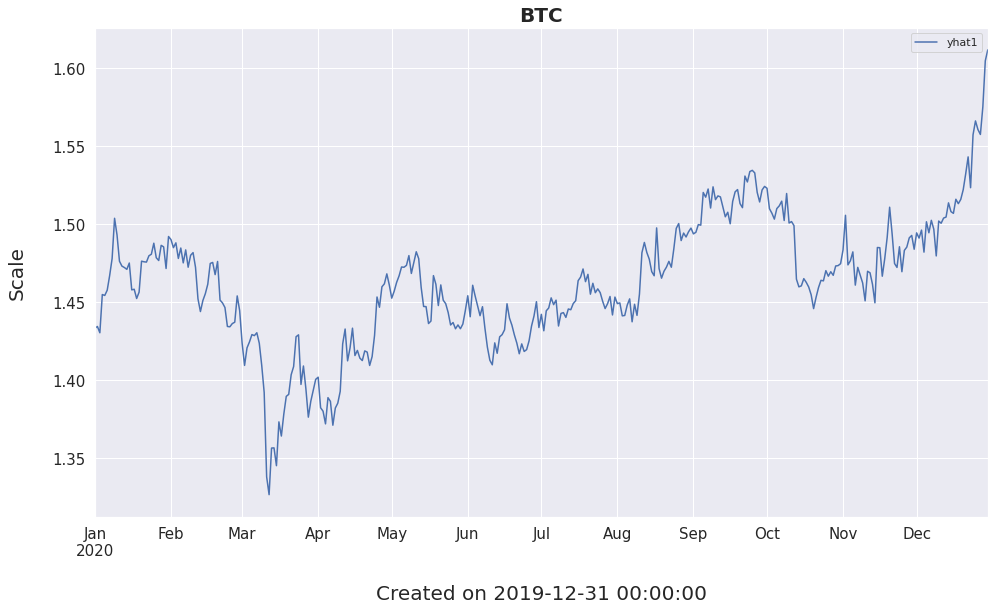

In [1]:
SEED = 9

import os
os.environ['PYTHONHASHSEED'] = str(SEED)

import random
random.seed(SEED)

import numpy as np
rng = np.random.default_rng(SEED) 
ss = rng.bit_generator._seed_seq # use for multiprocessing

from neuralprophet import set_random_seed
set_random_seed(SEED)

SEED_states_log = []

# -----------------------------------------------------------------------------------------
import sys
print(sys.version)
from IPython import display, get_ipython
from pprint import pprint as pp
import multiprocessing
import concurrent.futures
import datetime
import pandas as pd

from matplotlib import pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
sns.set()

import warnings
warnings.simplefilter(action='ignore')
np.seterr(divide = 'ignore')
# np.seterr(divide = 'warn')


from neuralprophet import NeuralProphet






tickers = (
"BTC",
"ETH",
"XMR",
"XRP",
)


reg=0.618



def np_forecast(ticker):
    
    set_random_seed(SEED)
    
    path = '///'
    file = '_' + ticker + '.csv'
    url = path + file
    df = pd.read_csv(url)

    df = df.rename(columns={"timestamp": "ds"})
    
#     df['r'] = df["y"].pct_change(1) # return
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ldf = len(df)
    hdf = len(df.columns)
    print('The number of rows in ' + ticker + ' dataset is', ldf)
    print('The number of columns in ' + ticker + ' dataset is', hdf)


    earliest = df.iloc[:1]['ds']
    earliest = pd.to_datetime(earliest).reset_index(drop=True)[0]
    earliest = earliest.strftime('%Y-%m-%d')


    latest = df.iloc[-1:]['ds']
    latest = pd.to_datetime(latest).reset_index(drop=True)[0]
    latest = latest.strftime('%Y-%m-%d')
    latest = pd.to_datetime(latest)

    year = latest + datetime.timedelta(days=1)
    year = year.strftime('%Y')
    print(year)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    modes = [
        "additive",
#         "multiplicative"
    ]

    e_modes = [
        "additive",
    #     "multiplicative"
    ]

#     https://neuralprophet.com/hyperparameter-selection/
    m = NeuralProphet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        
#         n_changepoints=45, #  108  320  331
        
        changepoints_range=0.618,
        trend_reg=reg,        
        num_hidden_layers=2,
    )


    future_regressors_list = list(filter(lambda i: i !="ds" and i !="y", df.columns))


    future_regressors_df = df.drop(['ds','y'] , axis='columns')

    for i in future_regressors_list:
        m = m.add_future_regressor(name=i, mode=e_modes[0])

    historical_events = pd.DataFrame({
            'event': 'btc_halving',
            'ds': pd.to_datetime(['2009-01-03', '2012-11-28', '2016-07-09', '2020-05-11',
                                  ]),

        })

    future_events = pd.DataFrame({
            'event': 'btc_halving',
            'ds': pd.to_datetime(['2024-03-01', '2028-03-01',
                                  '2032-03-01', '2036-03-01', '2040-03-01'
                                 ]),
        })

    history_events_df = historical_events
    future_events_df = future_events

    m = m.add_events(["btc_halving",
                     ],
                     mode=e_modes[0],
                     regularization=reg)

#     m.add_seasonality('monthly', period=365/12, fourier_order=5)
#     m.add_seasonality('monthly', period=365.24238/12, fourier_order=5)
#     m.add_seasonality('seasonly', period=365/4, fourier_order=7)
#     m.add_seasonality('24', period=365.24238/24, fourier_order=4)
#     m.add_seasonality('seasonly', period=350, fourier_order=10)
#     m.add_seasonality('moon', period=111, fourier_order=8)
#     m.add_seasonality('half_moon', period=365.24238/(365.24238/27.321661)/2, fourier_order=5)

    
    country = (
        "BR",
    #     "ID", # errors
    #     "IN", # errors
        "MY",
        "VN",
    #     "TH", # errors
        "PH",
        "PK",
        "BD",
        "EG",
        "CN",
        "RU",
        "KR",
        "BY",
        "AE",
        "US",
    )

    for i in country:
        m = m.add_country_holidays(i,
                                   mode=e_modes[0],
                                   regularization=reg)
    #                             )

    history_df = m.create_df_with_events(df, history_events_df)

    metrics = m.fit(history_df, freq="D", plot_live_loss=False, validate_each_epoch=True, valid_p=1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    ps = [
#         20,
#         30,
#         40,
#         50,
#         60,
#         90,
#         180,
#         360,
        365,
#         366,
#         1800,
    ]

    for _ in ps:
#         plt.ioff()
        display.clear_output(wait=True)
        future = m.make_future_dataframe(df=history_df,
                                         events_df=future_events_df,
                                         regressors_df=future_regressors_df,
                                         periods=_)
        forecast = m.predict(df=future)
        
        yf = forecast.assign(flag=forecast['yhat1'].gt(forecast['yhat1'].shift(1)))
        out = "///" + ticker + str(_) + "_signal.csv"
        yf["flag"].astype(int).to_csv(out,index=True)

        fig, ax = plt.subplots(figsize=(16,9))
        forecast.plot("ds","yhat1", xlabel="\nCreated on " + str(latest), ylabel="Scale\n", ax=ax)
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.set_title(ticker, fontsize=20, fontweight="bold")
        plt.savefig('///' + str(year) + "_" + ticker + "_" + str(_), bbox_inches='tight')
#         plt.close(fig)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
np_forecast("BTC")

# with concurrent.futures.ProcessPoolExecutor() as executor:
# # with concurrent.futures.ThreadPoolExecutor() as executor:
#     executor.map(np_forecast,tickers)
